# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, необходимо понять, какой тариф приносит больше денег. В рамках исследования необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

##  Этап 1. Изучение и обработка данных из файлов

### Описание данных

**Таблица users (информация о пользователях):**

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

**Таблица calls (информация о звонках):**

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Загрузка и осмотр датасетов

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import math

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import inspect

In [2]:
# Сформируем датасеты
calls = pd.read_csv(r"C:\Users\calls.csv")
internet = pd.read_csv(r"C:\Users\internet.csv")
messages = pd.read_csv(r"C:\Users\messages.csv")
tariffs = pd.read_csv(r"C:\Users\tariffs.csv")
users = pd.read_csv(r"C:\Users\users.csv")

#### Изучим датасет с пользователями

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [5]:
users.sample(n=5, random_state=None)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
251,1251,48,NaN,Пермь,Роксана,Тетерина,2018-02-13,smart
309,1309,28,NaN,Казань,Юлия,Касьянова,2018-10-05,ultra
284,1284,62,NaN,Волгоград,Евфросинья,Петухова,2018-03-16,smart
273,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra
269,1269,31,NaN,Омск,Аким,Ахмадулин,2018-07-17,smart


Есть пропущенные значения в столбце с датой прекращения пользования тарифом 'churn_date'.\
Согласно условиям, если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

#### Изучим датасет со звонками

In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [8]:
calls.sample(n=5, random_state=None)

,id,call_date,duration,user_id
76230,1189_898,2018-08-17,0.00,1189
139631,1356_615,2018-07-11,12.02,1356
110553,1284_151,2018-03-19,20.24,1284
108717,1281_150,2018-09-08,0.00,1281
135394,1345_203,2018-09-30,0.00,1345


Звонки с нулевой продолжительностью не ошибка — нулями обозначены пропущенные звонки, поэтому их не нужно удалять. \
Нужно поменять тип на DataTime в столбце с датой звонка 'call_date'.

#### Изучим датасет о сообщениях

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [11]:
messages.sample(n=5, random_state=None)

,id,message_date,user_id
64794,1278_8,2018-12-23,1278
76235,1323_238,2018-08-13,1323
53232,1235_110,2018-11-12,1235
84838,1354_290,2018-12-05,1354
32878,1145_531,2018-06-25,1145


Нужно поменять тип на DataTime в столбце с датой сообщения 'message_date'.

#### Изучим датасет об интернет-сессиях

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [13]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [14]:
internet.sample(n=5, random_state=None)

,Unnamed: 0,id,mb_used,session_date,user_id
48001,48001,1165_187,0.00,2018-11-02,1165
29321,29321,1102_195,0.00,2018-10-18,1102
7906,7906,1027_233,0.00,2018-10-24,1027
87687,87687,1297_28,782.38,2018-12-10,1297
70487,70487,1240_155,493.58,2018-04-21,1240


Нужно поменять тип на DataTime в столбце с датой интернет-сессии 'session_date'. Есть абоненты, которые не пользуются интернетом. \
Столбец 'Unnamed: 0' содержит дублирующие данные (индексы). Удалим этот столбец.

#### Изучим датасет о тарифах

In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [16]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [17]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Вывод

Далее:
* Исправим неверный формат даты в таблицах.
* Округлим время звонков и мегабайты трафика в большую сторону в соответствии с условиями тарифов.

## Этап 2. Предобработка данных

### Приведение данных к нужным типам

Во всех столбцах с датой, поменяем тип на date_time и зададим нужный формат.

In [18]:
# Датасет с пользователями
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [19]:
# Датасет со звонками
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [20]:
# Датасет с сообщениями
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [21]:
# Датасет об интернет-сессиях
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Обработка и исправление ошибок в данных

In [22]:
def dataset_duplicated(name_dataset):
    print('Обнаружено дубликатов:', name_dataset.duplicated().sum())

for ds in [users, calls, messages, internet, tariffs]:
    print()
    dataset_duplicated(ds)


Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0


In [23]:
# Проверим уникальность id в датасете users
users['user_id'].value_counts()

1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.\
Каждый звонок округляется отдельно — даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются.\
Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [24]:
# Округлим продолжительность звонков
calls['duration'] = np.ceil(calls['duration']).astype('Int64')

In [25]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [26]:
# Столбец 'Unnamed: 0' содержит дублирующие данные (индексы). Удалим этот столбец
internet.drop('Unnamed: 0', axis=1, inplace=True)

In [27]:
# Проверим, как прошло удаление
internet.sample(n=5, random_state=None)

,id,mb_used,session_date,user_id
119502,1403_57,718.76,2018-07-19,1403
13864,1047_110,316.71,2018-12-19,1047
126280,1424_141,500.93,2018-09-22,1424
17014,1059_20,297.56,2018-05-12,1059
40117,1142_198,211.22,2018-11-16,1142


Данные в исходных таблицах скорректированы, далее приступим к рассчётам.

### Расчёты и добавление результатов в таблицу

Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам.

In [28]:
# Добавим в датасеты колонки с месяцем 'month'
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

In [29]:
# Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам
user_calls = calls.groupby(['user_id', 'month']).\
                agg({'id':'count', 'duration':'sum'}).\
                reset_index().\
                rename(columns={'id':'calls_total_in_month', 'duration':'month_calls_duration'})
user_calls.head()

,user_id,month,calls_total_in_month,month_calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [30]:
user_calls.isna().sum()

user_id                 0
month                   0
calls_total_in_month    0
month_calls_duration    0
dtype: int64

In [31]:
# Посчитаем количество отправленных сообщений по месяцам
user_messages = messages.groupby(['user_id', 'month']).\
                    agg({'message_date':'count'}).\
                    reset_index().\
                    rename(columns={'message_date':'sms_total_in_month'})
user_messages.head()

,user_id,month,sms_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [32]:
user_messages.isna().sum()

user_id               0
month                 0
sms_total_in_month    0
dtype: int64

In [33]:
# Посчитаем объем израсходованного интернет-трафика по месяцам
user_internet = internet.groupby(['user_id', 'month']).\
                    agg({'mb_used':'sum'}).\
                    reset_index().\
                    rename(columns={'mb_used':'mb_total_in_month'})
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [34]:
user_internet.isna().sum()

user_id              0
month                0
mb_total_in_month    0
dtype: int64

**Посчитаем для каждого пользователя помесячную выручку с каждого пользователя.**

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [35]:
# Сформируем общую таблицу использования минут, смс и интернета для каждого id (помесячно)
df = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month
0,1000,5,22.0,159,22.0
1,1000,6,43.0,172,60.0
2,1000,7,47.0,340,75.0
3,1000,8,52.0,408,81.0
4,1000,9,58.0,466,57.0


In [36]:
df[df['month'].isna()]

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month


In [37]:
df = df.merge(user_internet, on=['user_id', 'month'], how='outer')
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month
0,1000,5,22.0,159,22.0,2253.49
1,1000,6,43.0,172,60.0,23233.77
2,1000,7,47.0,340,75.0,14003.64
3,1000,8,52.0,408,81.0,14055.93
4,1000,9,58.0,466,57.0,14568.91


In [38]:
df[df['month'].isna()]

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month


In [39]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [40]:
# Добавим данные из таблиц о пользователях 'users' и тарифах 'tariffs'
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,159,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [41]:
df[df['month'].isna()]

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff


In [42]:
df = df.merge(tariffs, on='tariff', how='outer')
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [43]:
df[df['month'].isna()]

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute


Исправим значения NaN на 0, это допустимо, так как пользователи с NaN по факту использовали в своём тарифе 0 минут, 0 смс, о Гб. 

Посмотрим, сколько у нас таких абонентов с 0 значениями.

In [44]:
df.isna().sum()

user_id                     0
month                       0
calls_total_in_month       40
month_calls_duration       40
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [45]:
df[['sms_total_in_month', 'mb_total_in_month', 'month_calls_duration', 'calls_total_in_month']] = \
        df[['sms_total_in_month', 'mb_total_in_month', 'month_calls_duration', 'calls_total_in_month']].fillna(0)

In [46]:
df.isna().sum()

user_id                     0
month                       0
calls_total_in_month        0
month_calls_duration        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [47]:
df.duplicated().sum()

0

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   calls_total_in_month   3214 non-null   float64       
 3   month_calls_duration   3214 non-null   Int64         
 4   sms_total_in_month     3214 non-null   float64       
 5   mb_total_in_month      3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

In [49]:
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [50]:
# Часть столбцов скрывается. Настроим принудительное отображение
pd.set_option('display.max_columns', None)

In [51]:
df.head()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Так как перерасход начисляется за гигабайты, логичнее весь Интернет трафик перевести в ГБ и переименовать столбцы.

In [52]:
df['mb_total_in_month'] = np.ceil(df['mb_total_in_month'] / 1024).astype(int)
df['mb_per_month_included'] = np.ceil(df['mb_per_month_included'] / 1024).astype(int)

In [53]:
df.sample(n=5, random_state=None)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1230,1054,3,30.0,237,28.0,11,33,NaT,Омск,Кристина,Платонова,2018-03-20,smart,50,15,500,550,200,3,3
115,1080,9,130.0,951,53.0,3,28,NaT,Москва,Всеволод,Игнатьев,2018-08-12,ultra,1000,30,3000,1950,150,1,1
704,1380,8,91.0,629,26.0,33,45,NaT,Ростов-на-Дону,Доминика,Карасева,2018-05-07,ultra,1000,30,3000,1950,150,1,1
1903,1194,12,55.0,403,54.0,14,70,NaT,Москва,Егор,Наумов,2018-12-03,smart,50,15,500,550,200,3,3
2923,1433,8,78.0,520,79.0,14,71,NaT,Подольск,Клариса,Алёшкова,2018-01-05,smart,50,15,500,550,200,3,3


In [54]:
df = df.rename(columns={'mb_total_in_month':'gb_total_in_month'})
df = df.rename(columns={'mb_per_month_included':'gb_per_month_included'})

In [55]:
df.sample(n=5, random_state=None)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
234,1143,12,97.0,813,0.0,23,64,NaT,Пермь,Арсен,Покровский,2018-04-27,ultra,1000,30,3000,1950,150,1,1
2159,1251,9,62.0,443,93.0,20,48,NaT,Пермь,Роксана,Тетерина,2018-02-13,smart,50,15,500,550,200,3,3
2418,1314,7,70.0,586,28.0,24,27,NaT,Киров,Максим,Амелишко,2018-03-04,smart,50,15,500,550,200,3,3
2420,1314,9,71.0,519,33.0,17,27,NaT,Киров,Максим,Амелишко,2018-03-04,smart,50,15,500,550,200,3,3
260,1152,9,42.0,288,0.0,21,44,NaT,Мурманск,Марина,Щербакова,2018-02-05,ultra,1000,30,3000,1950,150,1,1


In [56]:
df['minutes_overrun'] = [max(x-y, 0) for x, y in zip(df['month_calls_duration'], df['minutes_included'])]
df['messages_overrun'] = [max(x-y, 0) for x, y in zip(df['sms_total_in_month'], df['messages_included'])]
df['gb_overrun'] = [max(x-y, 0) for x, y in zip(df['gb_total_in_month'], df['gb_per_month_included'])]

In [57]:
df.sample(n=5, random_state=None)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun
1509,1116,4,19.0,168,0.0,10,65,NaT,Петрозаводск,Альберта,Шевцова,2018-04-17,smart,50,15,500,550,200,3,3,0,0.0,0
610,1348,11,81.0,515,40.0,27,55,NaT,Москва,Вероника,Громова,2018-10-07,ultra,1000,30,3000,1950,150,1,1,0,0.0,0
1047,1011,8,74.0,515,15.0,21,44,NaT,Самара,Веселина,Алёшко,2018-03-19,smart,50,15,500,550,200,3,3,15,0.0,6
570,1333,9,7.0,50,16.0,4,58,NaT,Москва,Вера,Антонова,2018-09-28,ultra,1000,30,3000,1950,150,1,1,0,0.0,0
2435,1317,10,94.0,678,32.0,18,45,NaT,Москва,Всеволод,Зыков,2018-07-09,smart,50,15,500,550,200,3,3,178,0.0,3


In [58]:
df.query("minutes_overrun != 0").head(5)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun
996,1005,3,77.0,606,56.0,11,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,106,6.0,0
997,1005,4,101.0,712,41.0,10,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,212,0.0,0
998,1005,5,73.0,595,42.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,95,0.0,0
999,1005,6,80.0,612,47.0,10,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,112,0.0,0
1000,1005,7,77.0,569,56.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,69,6.0,0


In [59]:
# Напишем функцию, которая считет выручку исходя из тарифа и потребляемых услуг
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_gb = 0
    
    # Cтоимость минут потраченных сверх тарифа
    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute']
        
    # Cтоимость сообщений потраченных сверх тарифа
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
        
    # Cтоимость Гб потраченных сверх тарифа
    if row['gb_overrun'] > 0:
        revenue_gb = row['gb_overrun'] * row['rub_per_gb']
    
    return revenue_by_min + revenue_by_messages + revenue_gb

In [60]:
df['revenue'] = df.apply(get_revenue, axis=1)

In [61]:
df.sample(n=5, random_state=None)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue
1228,1052,11,98.0,682,106.0,20,52,NaT,Санкт-Петербург,Павел,Панов,2018-07-27,smart,50,15,500,550,200,3,3,182,56.0,5,1714.0
251,1151,11,89.0,692,18.0,4,39,NaT,Пенза,Лариса,Молчанова,2018-09-15,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
1988,1216,12,198.0,1435,64.0,20,74,NaT,Волгоград,Рустам,Малинин,2018-11-23,smart,50,15,500,550,200,3,3,935,14.0,5,3847.0
1966,1211,10,58.0,448,20.0,19,62,NaT,Калуга,Арина,Азимова,2018-06-20,smart,50,15,500,550,200,3,3,0,0.0,4,800.0
895,1466,3,68.0,402,0.0,21,37,NaT,Новосибирск,Рубен,Шевцов,2018-02-28,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0


Мы рассчитали переплату за превышение пакетных услуг для каждого пользователя, теперь найдём общую выручку, добавив стоимость абонентской платы за тариф к переплате.

In [62]:
df['income'] = df['revenue'] + df['rub_monthly_fee']

In [63]:
df.sample(n=5, random_state=None)

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
1332,1071,6,46.0,313,23.0,19,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15,500,550,200,3,3,0,0.0,4,800.0,1350.0
114,1080,8,73.0,476,57.0,5,28,NaT,Москва,Всеволод,Игнатьев,2018-08-12,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
2934,1435,7,41.0,234,0.0,20,32,NaT,Москва,Евфросинья,Азимова,2018-02-17,smart,50,15,500,550,200,3,3,0,0.0,5,1000.0,1550.0
3008,1457,5,70.0,490,28.0,23,35,NaT,Саратов,Татьяна,Авчинникова,2018-03-14,smart,50,15,500,550,200,3,3,0,0.0,8,1600.0,2150.0
1041,1010,12,32.0,336,0.0,19,26,NaT,Тюмень,Эдуард,Кононов,2018-08-05,smart,50,15,500,550,200,3,3,0,0.0,4,800.0,1350.0


### Вывод

Мы привели исходные данные к нужным типам, обработали ошибки, объединили данные из нескольких таблиц в одну удобную и рассчитали новые столбцы. Нам удалось выяснить переплату каждого абонента за использование услуг сверх своего тарифного плана и общую сумму выручки с каждого абонента.

## Этап 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки.

1. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.
2. Посчитаем среднее количество, дисперсию и стандартное отклонение.
3. Построим гистограммы.
4. Опишем распределения.

In [64]:
# Вспомним условия тарифов, чтобы сравнить с показателями describe
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Для удобства обращения к данным, разделим общую таблицу на две по используемую абонентом тарифу 'Smart' и 'Ultra'.
Проанализируем каждую из этих таблиц.

In [65]:
# Посмотрим количество строк для каждого тарифа
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

### Анализ тарифа 'Smart'

In [66]:
smart_df = df.query("tariff == 'smart'")
smart_df.describe().round()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
count,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0
mean,1247.0,8.0,58.0,418.0,33.0,16.0,47.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,42.0,6.0,3.0,740.0,1290.0
std,146.0,3.0,26.0,190.0,28.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,13.0,4.0,818.0,818.0
min,1001.0,1.0,0.0,0.0,0.0,0.0,18.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,0.0,0.0,550.0
25%,1121.0,6.0,40.0,282.0,10.0,13.0,32.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,0.0,0.0,550.0
50%,1239.0,9.0,60.0,422.0,28.0,17.0,47.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,2.0,473.0,1023.0
75%,1376.0,11.0,76.0,545.0,51.0,20.0,62.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,45.0,1.0,5.0,1200.0,1750.0
max,1499.0,12.0,198.0,1435.0,143.0,38.0,75.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,935.0,93.0,23.0,6220.0,6770.0


#### Анализ звонков

In [67]:
smart_df['month_calls_duration'].describe().round()

count    2229.0
mean      418.0
std       190.0
min         0.0
25%       282.0
50%       422.0
75%       545.0
max      1435.0
Name: month_calls_duration, dtype: float64

In [68]:
variance = np.var(smart_df['month_calls_duration'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Сренднее количество: ', smart_df['month_calls_duration'].mean().round(2))

Дисперсия:  36219.32
Стандартное отклонение:  190.31
Сренднее количество:  417.93


Text(0.5, 0, 'Продолжительность звонков Smart')

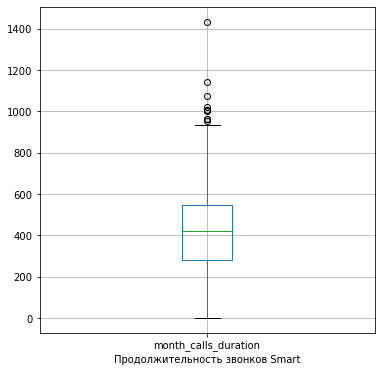

In [69]:
smart_df.boxplot('month_calls_duration', figsize=(6,6))
plt.xlabel('Продолжительность звонков Smart')

In [70]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

Text(0.5, 0, 'Динамика звонков по месяцам')

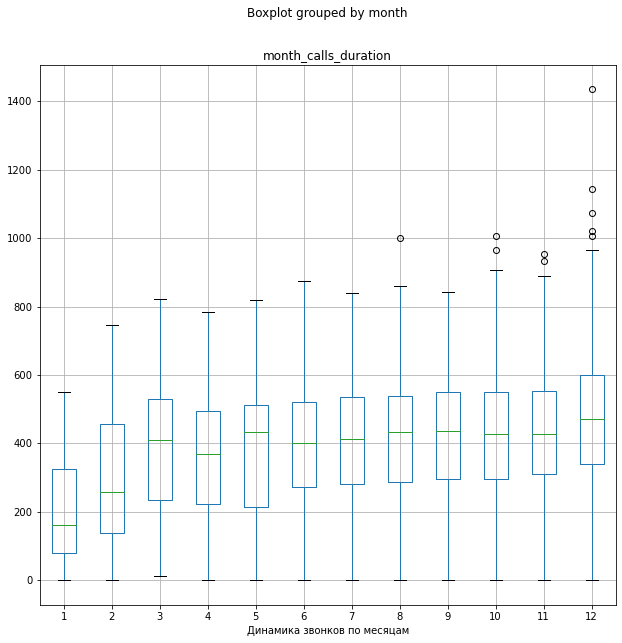

In [71]:
smart_df.boxplot('month_calls_duration', by='month', figsize=(10,10))
plt.xlabel('Динамика звонков по месяцам')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Частота')

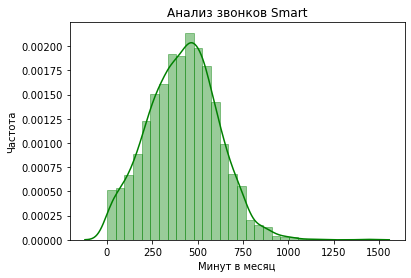

In [72]:
sns.distplot(smart_df['month_calls_duration'], 
             hist=True, bins=30, 
             color='g', hist_kws={'edgecolor':'g'}).set_title('Анализ звонков Smart')
plt.xlabel('Минут в месяц')
plt.ylabel('Частота')

Краткий вывод:
* Распределение нормальное;
* Близкое расположение нормального и среднего значений;
* Среднее количество минут приближается к тарифному лимиту и при этом среднее отклонение (190 мин.) составляет 38% от лимита (500 мин.) - абоненты не укладываются в лимит и приобретают дополнительные минуты.

In [73]:
# Вычислим % отношение выручки от минут сверх тарифного плана к общей выручке
(smart_df.query("minutes_overrun > 0")['minutes_overrun'].sum() * 3) / smart_df['income'].sum()

0.09675931738420805

Выручка от минут сверх тарифного плана составляет почти 10% ко всей выручке по тарифу.

In [74]:
# Посчитаем % отношение выручки от минут сверх тарифного плана к выручке по абон.плате (2229 абонетов по 550 руб.)
(smart_df.query("minutes_overrun > 0")['minutes_overrun'].sum() * 3) / (2229 * 500)

0.24963391655450876

Выручка от минут сверх тарифного плана составляет почти 25% к выручке по абон.плате.

In [75]:
# Посчитаем количество наблюдений с превышением количества минут по тарифу Smart
smart_df.query("minutes_overrun > 0")['minutes_overrun'].count()

754

754 наблюдения с превышением количества пакетных минут по тарифу 'Smart'.

Посмотрим, есть ли абоненты на Smart, которые использовали бы все 3000 минут на тарифе 'Ultra'.

In [76]:
smart_df[smart_df['month_calls_duration'] > 3000]['month_calls_duration'].count()

0

Таких данных не обнаружено.

#### Анализ интернет-трафика

In [77]:
smart_df['gb_total_in_month'].describe().round()

count    2229.0
mean       16.0
std         6.0
min         0.0
25%        13.0
50%        17.0
75%        20.0
max        38.0
Name: gb_total_in_month, dtype: float64

In [78]:
variance = np.var(smart_df['gb_total_in_month'], ddof=1)
print('Дисперсия: ', variance)
print('Стандартное отклонение: ', np.sqrt(variance))
print('Среднее количество: ', smart_df['gb_total_in_month'].mean())

Дисперсия:  33.02870517811158
Стандартное отклонение:  5.747060568509052
Среднее количество:  16.328847016599372


Text(0.5, 0, 'Объём трафика Smart')

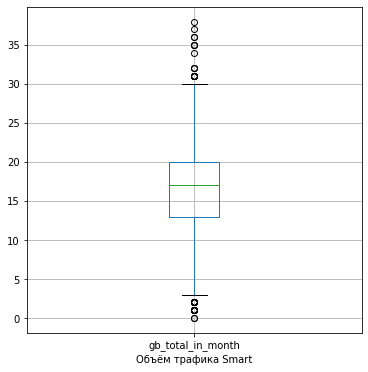

In [79]:
smart_df.boxplot('gb_total_in_month', figsize=(6,6))
plt.xlabel('Объём трафика Smart')

Text(0.5, 0, 'Динамика трафика по месяцам')

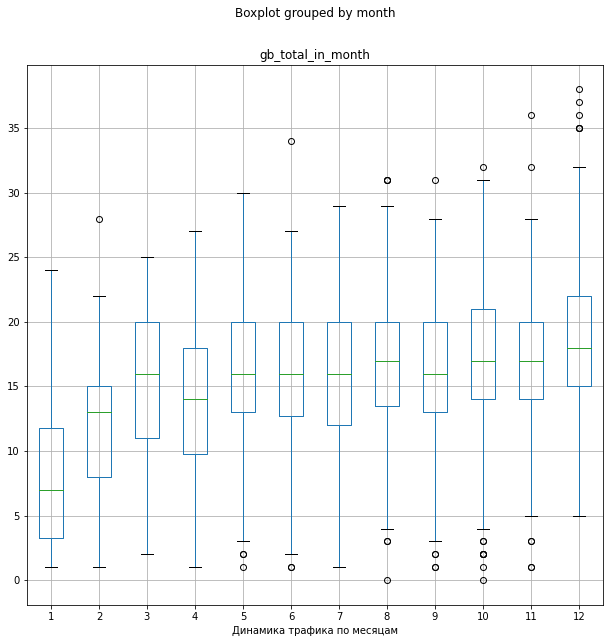

In [80]:
smart_df.boxplot('gb_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика трафика по месяцам')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Гб в месяц')

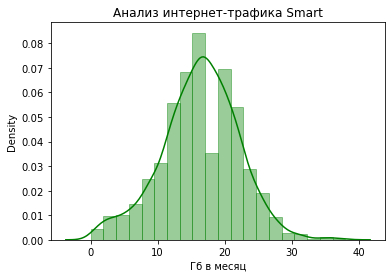

In [81]:
sns.distplot(smart_df['gb_total_in_month'], 
             hist=True, bins=20,
             color='g', hist_kws={'edgecolor':'g'}).set_title('Анализ интернет-трафика Smart')
plt.xlabel('Гб в месяц')

Краткий вывод:
* Распределение нормальное — 15Гб входящих в пакетное предложение ниже среднего (16.37Гб);
* Большая часть абонентов платит за доплнительные Гб;
* Чем ниже среднего лимит, тем больше прибыли получает оператор сотовой связи «Мегалайн».

In [82]:
# Количество дополнительных gb
smart_df.query('gb_overrun > 0')['gb_overrun'].sum()

6662

In [83]:
# Количество тарифных gb
smart_df.query('gb_overrun < 0')['gb_overrun'].sum()

0

In [84]:
(((smart_df.query('gb_overrun > 0')['gb_overrun'].sum() * 200) / smart_df['income'].sum()) * 100).round(2)

46.34

Выручка от дополнительно купленных Гб интернета составляет 46% от общей выручки по тарифу.
Интересный результат.

In [85]:
(smart_df.query('gb_overrun > 0')['gb_overrun'].sum() * 200) / (2229 * 550)

1.0868306211509442

Выручка от дополнительно купленных Гб интернета больше выручки от тарифа по лимиту (2229 наблюдений * 550 руб./мес.) почти на 110%.

In [86]:
smart_15 = smart_df.query('gb_overrun > 0')['gb_overrun'].count()
smart_15

1304

Лимит 15Гб был превышен 1304 раза.

In [87]:
smart_15 / 2229

0.5850157021085689

Почти в 59% наблюдений был превышен пакетный лимит 15Гб.

In [88]:
smart_30 = smart_df.query('gb_total_in_month > 30')['gb_total_in_month'].count()
smart_30

18

Порог тарифа 'Ultra' 30 Гб был превышен абонентами тарифа 'Smart' 18 раз.

#### Анализ сообщений

In [89]:
smart_df['sms_total_in_month'].describe().round()

count    2229.0
mean       33.0
std        28.0
min         0.0
25%        10.0
50%        28.0
75%        51.0
max       143.0
Name: sms_total_in_month, dtype: float64

In [90]:
variance = np.var(smart_df['sms_total_in_month'], ddof=1)
print('Дисперсия: ', variance)
print('Стандартное отклонение: ', np.sqrt(variance))
print('Среднее количество: ', smart_df['sms_total_in_month'].mean())

Дисперсия:  796.8129584480083
Стандартное отклонение:  28.22787555676141
Среднее количество:  33.384028712427096


Text(0.5, 0, 'Сообщения Smart')

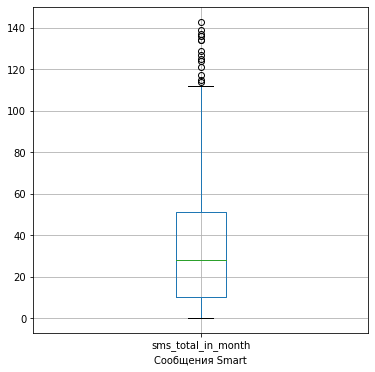

In [91]:
smart_df.boxplot('sms_total_in_month', figsize=(6,6))
plt.xlabel('Сообщения Smart')

Text(0.5, 0, 'Динамика sms по месяцам')

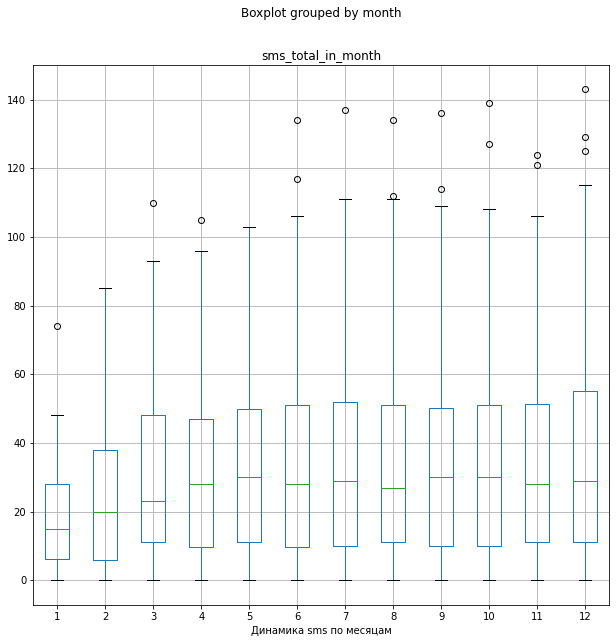

In [92]:
smart_df.boxplot('sms_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика sms по месяцам')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Частота')

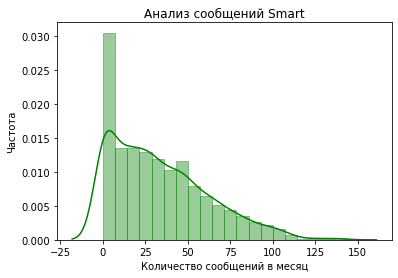

In [93]:
sns.distplot(smart_df['sms_total_in_month'],
            hist=True, bins=20,
            color='g', hist_kws={'edgecolor':'g'}).set_title('Анализ сообщений Smart')
plt.xlabel('Количество сообщений в месяц')
plt.ylabel('Частота')

Краткий вывод:

* Распределение скошено вправо — 25% от всех месяцев использовали менее 10 сообщений;
* А 75% абонентов - укладывались в пакетные 50 сообщений;
* Только 25% отправляли дополнительные сообщения;
* Среднее количество отправляемых сообщений 33 немного больше среднего по лимиту тарифа (т.е. 25 сообщений из 50).

In [94]:
# Количество дополнительных сообщений
smart_df.query('messages_overrun > 0')['messages_overrun'].sum()

12928.0

In [95]:
# Выручка от дополнительных сообщений
(smart_df.query('messages_overrun > 0')['messages_overrun'].sum() * 3) / (2229 * 550)

0.03163587421999266

Выручка от дополнительных сообщений составляет 3% к абонентской плате.

In [96]:
(smart_df.query('messages_overrun > 0')['messages_overrun'].sum() * 3) / smart_df['income'].sum()

0.01348844019391024

Выручка от дополнительных сообщений составляет всего 1,3% ко всей выручке по тарифу.

Это вполне объяснимо, так как при использовании интернета потребность в SMS практически отпала.

### Анализ тарифа 'Ultra'

In [97]:
ultra_df = df.query("tariff == 'ultra'")
ultra_df.describe().round()

,user_id,month,calls_total_in_month,month_calls_duration,sms_total_in_month,gb_total_in_month,age,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
count,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
mean,1263.0,8.0,73.0,527.0,49.0,19.0,47.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,1.0,120.0,2070.0
std,141.0,3.0,44.0,318.0,48.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,376.0,376.0
min,1000.0,1.0,0.0,0.0,0.0,0.0,18.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
25%,1143.0,6.0,41.0,284.0,6.0,12.0,30.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
50%,1277.0,9.0,74.0,518.0,38.0,19.0,45.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
75%,1381.0,11.0,104.0,752.0,79.0,27.0,63.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
max,1495.0,12.0,244.0,1673.0,224.0,49.0,75.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,19.0,2850.0,4800.0


<AxesSubplot:>

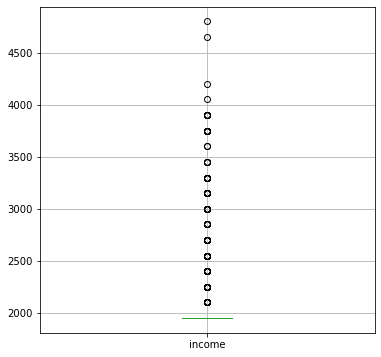

In [98]:
ultra_df.boxplot('income', figsize=(6,6))

In [99]:
# Сколько наблюдений превышают плату за тариф
ultra_df.query("income > 1950")['income'].count()

134

In [100]:
# Сколько % наблюдений превышают плату за тариф
ultra_df.query("income > 1950")['income'].count() / 985 * 100

13.604060913705585

In [101]:
# Какие суммы платят те, кто выходят за рамки тарифа
ultra_df['income'].value_counts()

1950.0    851
2250.0     21
2400.0     18
2550.0     13
2100.0     12
3000.0     10
2700.0     10
3150.0      9
3750.0      9
3300.0      9
2850.0      7
3900.0      6
3450.0      4
3600.0      2
4200.0      1
4800.0      1
4050.0      1
4650.0      1
Name: income, dtype: int64

#### Анализ звонков

In [102]:
ultra_df['month_calls_duration'].describe().round()

count     985.0
mean      527.0
std       318.0
min         0.0
25%       284.0
50%       518.0
75%       752.0
max      1673.0
Name: month_calls_duration, dtype: float64

In [103]:
variance = np.var(ultra_df['month_calls_duration'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Сренднее количество: ', ultra_df['month_calls_duration'].mean().round(2))

Дисперсия:  100873.63
Стандартное отклонение:  317.61
Сренднее количество:  526.62


Text(0.5, 0, 'Продолжительность звонков Ultra')

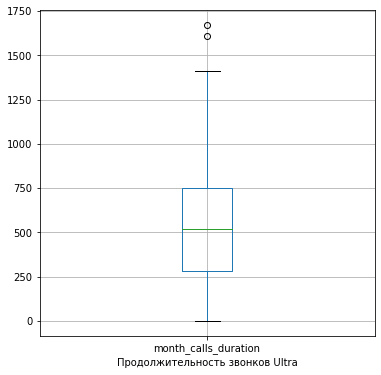

In [104]:
ultra_df.boxplot('month_calls_duration', figsize=(6,6))
plt.xlabel('Продолжительность звонков Ultra')

Text(0.5, 0, 'Продолжительность звонков Ultra')

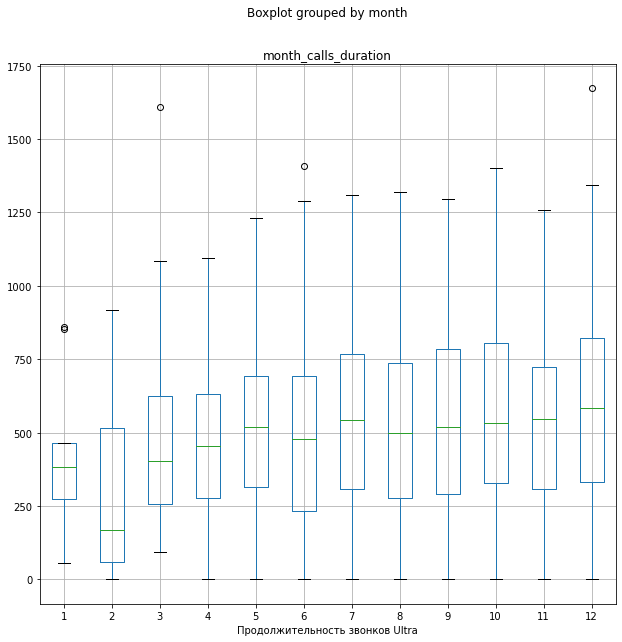

In [105]:
ultra_df.boxplot('month_calls_duration', by='month', figsize=(10,10))
plt.xlabel('Продолжительность звонков Ultra')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Частота')

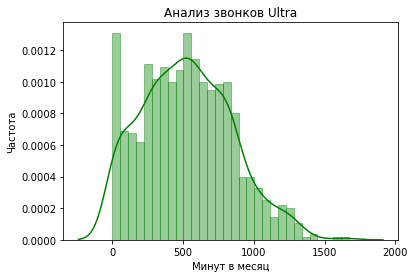

In [106]:
sns.distplot(ultra_df['month_calls_duration'],
            hist=True, bins=30,
            color='g', hist_kws={'edgecolor':'g'}).set_title('Анализ звонков Ultra')
plt.xlabel('Минут в месяц')
plt.ylabel('Частота')

Краткий вывод:

* Распределение чуть скошено влево, распределение умеренно ассиметричное;
* Среднее значение и медиана лежат близко друг к другу;
* Почти половина абонентов используют до 500 минут в месяц из максимально возможных 3000 минут;
* Высока частота пользователей, которые минимально пользуются минутами;
* Абонентов превышающих тарифный лимит по минутам не обнаружено, значит нет и дополнительной выручки.

#### Анализ интернет-трафика

In [107]:
ultra_df['gb_total_in_month'].describe().round()

count    985.0
mean      19.0
std       10.0
min        0.0
25%       12.0
50%       19.0
75%       27.0
max       49.0
Name: gb_total_in_month, dtype: float64

In [108]:
variance = np.var(ultra_df['gb_total_in_month'], ddof=1)
print('Дисперсия: ', variance)
print('Стандартное отклонение: ', np.sqrt(variance))
print('Сренднее количество: ', ultra_df['gb_total_in_month'].mean())

Дисперсия:  97.09168626965472
Стандартное отклонение:  9.8535113675103
Сренднее количество:  19.494416243654822


Text(0.5, 0, 'Объём трафика Ultra')

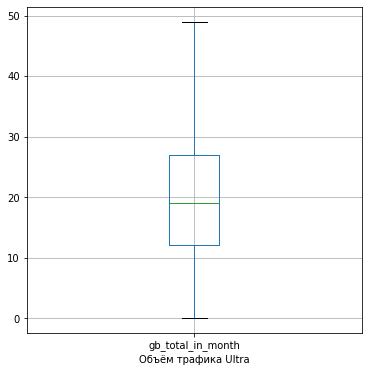

In [109]:
ultra_df.boxplot('gb_total_in_month', figsize=(6,6))
plt.xlabel('Объём трафика Ultra')

Text(0.5, 0, 'Динамика трафика по месяцам')

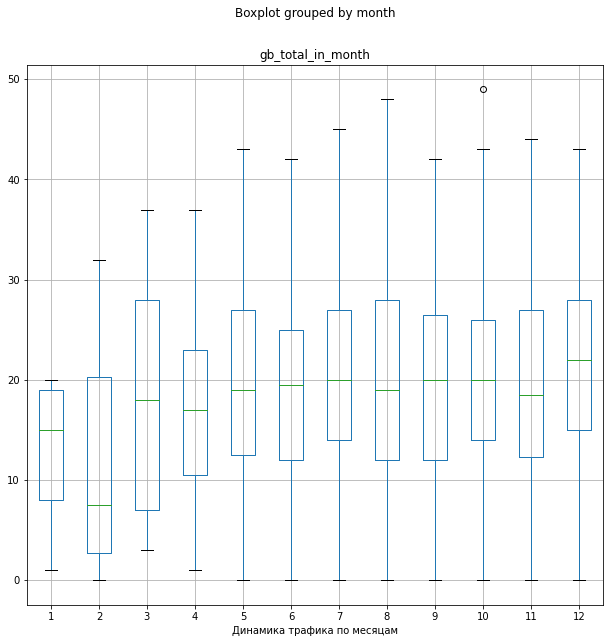

In [110]:
ultra_df.boxplot('gb_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика трафика по месяцам')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Гб в месяц')

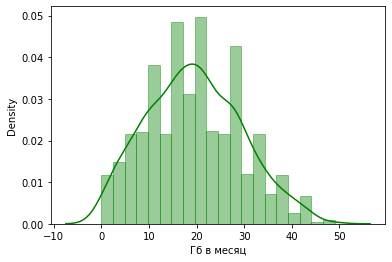

In [111]:
sns.distplot(ultra_df['gb_total_in_month'],
            hist=True, bins=20,
            color='g', hist_kws={'edgecolor':'g'}).set_label('Анализ интернет-трафика Ultra')
plt.xlabel('Гб в месяц')

Краткий вывод:

* В тариф 'Ultra' включено 30 Гб интернет-трафика;
* Распределение нормальное, т.к. интернетом пользуются полноценно, звонки и сообщения часто через приложения и соответственно при помощи интернета;
* Среднее и медиана схожи и составлют приблизительно 19-20 Гб;
* 75% абонентов укладываются в лимит (27 из 30 Гб).

In [112]:
# Количество дополнительных gb
ultra_df.query("gb_overrun > 0")['gb_overrun'].sum()

789

In [113]:
(((ultra_df.query('gb_overrun > 0')['gb_overrun'].sum() * 150) / smart_df['income'].sum()) * 100).round(2)

4.12

In [114]:
((ultra_df.query('gb_overrun > 0')['gb_overrun'].sum() * 150) / ((985 * 1950)) * 100).round(2)

6.16

Общее количество дополнительного трафика составляет 789 Гб, или 4.12% от общей выручки по тарифу. 
Выручка за дополнительные Гб на 6.16% больше выручки, чем по тарифу (985 наблюдений * 1950 руб./мес.).

#### Анализ сообщений

In [115]:
ultra_df['sms_total_in_month'].describe().round()

count    985.0
mean      49.0
std       48.0
min        0.0
25%        6.0
50%       38.0
75%       79.0
max      224.0
Name: sms_total_in_month, dtype: float64

In [116]:
def round_up(number:float, digits:int):
    return math.ceil(number * 10**digits) / 10**digits

In [117]:
variance = np.var(ultra_df['sms_total_in_month'], ddof=1)
print('Дисперсия: ', round_up(variance, 2))
print('Стандартное отклонение: ', round_up(np.sqrt(variance), 2))
print('Сренднее количество: ', round_up(ultra_df['sms_total_in_month'].mean(), 2))

Дисперсия:  2285.27
Стандартное отклонение:  47.81
Сренднее количество:  49.37


Text(0.5, 0, 'Сообщения Ultra')

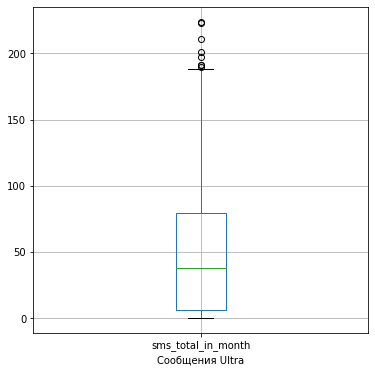

In [118]:
ultra_df.boxplot('sms_total_in_month', figsize=(6,6))
plt.xlabel('Сообщения Ultra')

Text(0.5, 0, 'Динамика sms по месяцам')

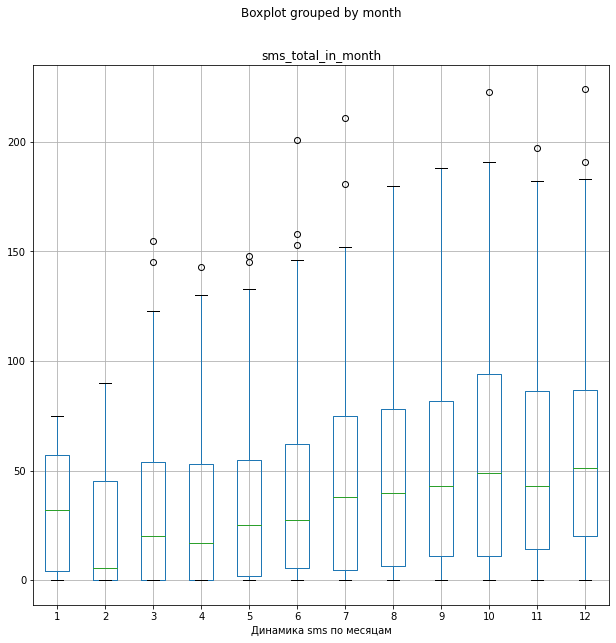

In [119]:
ultra_df.boxplot('sms_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика sms по месяцам')

C:\Users\Emachines\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Частота')

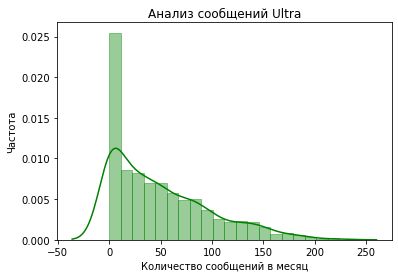

In [120]:
sns.distplot(ultra_df['sms_total_in_month'],
            hist=True, bins=20,
            color='g', hist_kws={'edgecolor':'g'}).set_title('Анализ сообщений Ultra')
plt.xlabel('Количество сообщений в месяц')
plt.ylabel('Частота')

Краткий вывод:

* Распределение имеет правостороннюю ассиметрию;
* Лимит SMS сообщений в тарифе 'Ultra' составляет 1000 сообщений. Максимальное количество отправленных сообщений составляет 224 сообщения, что говорит о том, что они себя практически изжили. Таким образом, включать в пакет тарифа 'Ultra' 1000 SMS со стороны оператора довольно выгодно.

In [121]:
print('Уложились бы в лимит 50 SMS:', ultra_df.query('sms_total_in_month <= 50')['sms_total_in_month'].count())

Уложились бы в лимит 50 SMS: 586


In [122]:
(ultra_df.query('sms_total_in_month <= 50')['sms_total_in_month'].count() / 985 * 100).round(2)

59.49

Почти 60% абонентов тарифа 'Ultra' уложились бы в лимит 'Smart' (50 сообщений).

#### Вывод

В тариф 'Ultra' включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика. Сумма абонентской платы составляет 1950 рублей.

* Максимальное количество использованных минут разговора за месяц составило 1673 минут, отправленных сообщений — 224, что не превышает лимит;
* Максимальный объем использованного интернет-трафика в месяц равен 49 Гб, причем в более чем 75% наблюдений лимит не превышался;
* Превышение абонентской платы за тариф было только в 13% наблюдений.

In [123]:
df.pivot_table(index='tariff', 
               values=['month_calls_duration', 'gb_total_in_month', 'sms_total_in_month'], 
               aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

## Этап 4. Проверка гипотез

### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Перед проверкой гипотез нужно избавиться от выбросов. Например, методом 3-х сигм. Выбросы влияют на распределение t-критерия.

In [124]:
def del_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

In [125]:
# Проверка правильности работы функции
# del_outliers(df, 'income', graphic=1)
# q1 = df['income'].quantile(0.25)                 
# q3 = df['income'].quantile(0.75)
# iqr = q3 - q1
# df.loc[(df['income'] >= (q1 - 1.5 * iqr)) & (df['income'] <= (q3 + 1.5 * iqr))].boxplot(['income'], figsize=(10,10))

In [126]:
moscow = del_outliers(df.query('city == "Москва"'), 'income', 0)
moscow = moscow['income']

other = del_outliers(df.query('city != "Москва"'), 'income', 0)
other = other['income']

In [127]:
smart = del_outliers(df.query('tariff == "smart"'), 'income', 0)
smart = smart['income']

ultra = del_outliers(df.query('tariff == "ultra"'), 'income', 0)
ultra = ultra['income']

In [128]:
# Посмотрим выручку по тарифу 'smart' до удаления выбросов
df.query('tariff == "smart"')['income'].describe().round()

count    2229.0
mean     1290.0
std       818.0
min       550.0
25%       550.0
50%      1023.0
75%      1750.0
max      6770.0
Name: income, dtype: float64

In [129]:
# Посмотрим выручку по тарифу 'smart' после удаления выбросов
smart.describe().round()

count    2198.0
mean     1246.0
std       730.0
min       550.0
25%       550.0
50%      1006.0
75%      1750.0
max      3550.0
Name: income, dtype: float64

In [130]:
# Посмотрим выручку по тарифу 'ultra' до удаления выбросов
df.query('tariff == "ultra"')['income'].describe().round()

count     985.0
mean     2070.0
std       376.0
min      1950.0
25%      1950.0
50%      1950.0
75%      1950.0
max      4800.0
Name: income, dtype: float64

In [131]:
# Посмотрим выручку по тарифу 'ultra' после удаления выбросов
ultra.describe().round()

count     851.0
mean     1950.0
std         0.0
min      1950.0
25%      1950.0
50%      1950.0
75%      1950.0
max      1950.0
Name: income, dtype: float64

Средняя выручка по тарифам "Смарт" и "Ультра" до удаления выбросов равны 1290 руб. и 2070 руб соответственно.\
Средняя выручка по тарифам "Смарт" и "Ультра" после удаления выбросов равны 1246 руб. и 1950 руб соответственно.

**Сформулируем гипотезы:**

H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается. \
H1: выручка пользователей тарифов «Ультра» и «Смарт» различается.

Используем метод scipy.stats.ttest_ind(array1, array2, equal_var = False). False, потому что дисперсии наших выборок отличаются. Критический уровень значимости 0.01. Пусть вероятность правильности вывода будет 99% и больше.

In [132]:
print(inspect.getsource(del_outliers))

def del_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]



In [133]:
# До удаления выбросов
alpha = 0.01

results = st.ttest_ind(df.query("tariff == 'smart'")['income'], df.query("tariff == 'ultra'")['income'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу.


Нулевой гипотезой была гипотеза о неравенстве средних наших выборок и очень маленькое p-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается.

In [134]:
# До удаления выбросов
alpha = 0.01

results = st.ttest_ind(smart, ultra, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 4.665521e-316
Отвергаем нулевую гипотезу.


**Вывод по гипотезе 1:**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок и очень маленькое p-value означает, что вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается.

А значит альтернативная гипотеза о том, что средние наших выборок отличаются, не отвергается! \
Выручка между двумя тарифами отличается, но так как гипотеза двухсторонняя, то сама проверка не даёт нам понять в какую именно сторону оно отличается, и что приносит больше выручки.\
Но как мы уже выяснили ранее: средняя выручка по тарифам "Ультра" и "Смарт" равны 1290 руб. и 2070 руб соответственно.

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [135]:
print('Уникальные значения названия города')
print(df['city'].value_counts())

Уникальные значения названия города
Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Нижневартовск        6
Сургут               6
Химки                5
Кемерово             5
Иваново              2
Name: city, Length: 76, dtype: int64


In [136]:
# Посмотрим выручку в Москве до удаления выбросов
df.query("city == 'Москва'")['income'].describe().round()

count     611.0
mean     1547.0
std       752.0
min       550.0
25%       780.0
50%      1750.0
75%      1950.0
max      5321.0
Name: income, dtype: float64

In [137]:
# Посмотрим выручку в Москве после удаления выбросов
moscow.describe().round()

count     606.0
mean     1525.0
std       713.0
min       550.0
25%       758.0
50%      1750.0
75%      1950.0
max      3450.0
Name: income, dtype: float64

In [138]:
# Посмотрим выручку по другим регионам до удаления выбросов
df.query("city != 'Москва'")['income'].describe().round()

count    2603.0
mean     1525.0
std       809.0
min       550.0
25%       750.0
50%      1583.0
75%      1950.0
max      6770.0
Name: income, dtype: float64

In [139]:
# Посмотрим выручку по другим регионам после удаления выбросов
other.describe().round()

count    2572.0
mean     1490.0
std       743.0
min       550.0
25%       750.0
50%      1552.0
75%      1950.0
max      3750.0
Name: income, dtype: float64

Средняя выручка до удаления выбросов пользователей из Москвы и других городов равны 1547 руб. и 1525 руб соответственно. \
Средняя выручка после удаления выбросов пользователей из Москвы и других городов равны 1525 руб. и 1490 руб соответственно. \
Средние выручки практически действительно равны, есть лишь небольшое различие.

**Сформулируем гипотезы:**

H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. \
H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [140]:
# До удаления выбросов
alpha = 0.01

results = st.ttest_ind(df.query("city == 'Москва'")['income'], df.query("city != 'Москва'")['income'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу.


In [141]:
# До удаления выбросов
alpha = 0.01

results = st.ttest_ind(moscow, other, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.28193534711211565
Не получилось отвергнуть нулевую гипотезу.


Полученное нами p-value достаточно велик, а значит есть большая вероятность того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних мы отвергаем!

## Этап 5. Результаты исследования

### Выводы

* В ходе исследования тарифов «Смарт» и «Ультра» на выборке из 500 пользователей мы обработали несколько массивов данных. \
Из предоставленных нам таблиц мы определили все необходимые средние значения израсходованных минут, сообщений и мегабайтов интернет-трафика. Вычислили прибыль по каждому месяцу и посчитали по каждому из клиентов среднюю прибыль для компании. Далее разделили всех клиентов по тарифным группам и проверили правильность наших гипотез.


* Самый популярным тарифом оказался «Смарт».


* Средняя выручка по тарифам «Смарт» и «Ультра» равны 1290 руб. и 2070 руб соответственно.


* Средние израсходованные количества звонков, сообщений и мегабайт интернет трафика не так сильно отличаются между тарифами, в то время как базовая стоимость тарифов отличается почти в 4 раза.


* 75% абонентов «Смарт» не укладываются в лимит и платит за допольнительный трафик, чем приносит оператору порядка 46% выручки от тарифа. Средний ежемесячный платёж в два раза превышает абонентскую плату.


* Более 25% абонентов «Смарт» используют дополнительные минуты и сообщения.


* Максимальное количество в месяц сообщений минут на тарифе «Ультра» не превышает лимит и не приносит дополнительной выручки. У более чем 75% наблюдений лимит по интернет-трафику также не превышался. Только 13% наблюдений превышают абонентскую плату за тариф


* Средние выручки Москвы и остальных регионов практически равны, имеется небольшое различие.

### Рекомендации

* Оператору можно порекомендовать скорректировать рекламный бюджет в пользу тарифа «Смарт».\
Он приносит больше выручки, за счёт того, что его абоненты переплачивают сверх лимита, в отличие от абонентов «Ультра», которые крайне редко выбирают свой лимит.


* Также по абонентской плате тариф «Смарт» более привлекателен для абонентов, а значит может быть более популярным и будет приносить суммарно большую выручку.\
Для привлечения клиентов можно дополнительно уменьшить абонентскую плату на первые месяцы или добавить в этот тариф минуты и сообщения.


* Но если учитывать, что тариф «Ультра» приносит выручку на 38% больше, чем «Смарт», то стоит оценить стоимость привлечения одного абонента по каждому тарифу. И исходя из сравнения стоимости привлечения делать более точные оценки.

**Описание тарифов**

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

**Таблица users (информация о пользователях):**

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

**Таблица calls (информация о звонках):**

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)